# Loading Library


In [1]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2

# Loading Data



In [2]:
# Defining the path for train and test images

data_dir_train = pathlib.Path(r"C:\Users\manju\SKIN_CANCER_NEW\skin-cancer-malignant-vs-benign\train")
data_dir_test = pathlib.Path(r"C:\Users\manju\SKIN_CANCER_NEW\skin-cancer-malignant-vs-benign\test")

In [3]:
# Here we have the 2637 train and 660 test
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("The number of Train data:",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("The Number of Test data:",image_count_test)

The number of Train data: 2637
The Number of Test data: 660


In [4]:
# This Parameter we can use it in the network and model
batch_size = 32
img_height = 180
img_width = 180

In [5]:
# For train data set
train_ds = image_dataset_from_directory(data_dir_train, 
                                        seed = 123, 
                                        image_size=(img_height, img_width), 
                                        validation_split=0.2, 
                                        subset='training')

Found 2637 files belonging to 2 classes.
Using 2110 files for training.


In [6]:
# here we can put the validate data
val_ds = image_dataset_from_directory(data_dir_train, 
                                      seed = 123, 
                                      image_size=(img_height, img_width), 
                                      validation_split=0.2, 
                                      subset='validation')

Found 2637 files belonging to 2 classes.
Using 527 files for validation.


In [7]:
# Here We give the name of the data the we found the Benign dataset and malignant
class_names = train_ds.class_names
print(type(class_names), class_names)

<class 'list'> ['benign', 'malignant']


# Here we can show some of data 

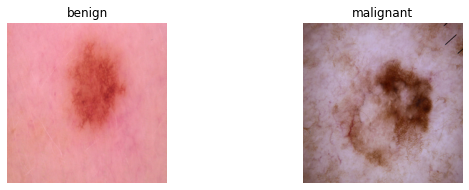

In [8]:
### Visualizing the training data

plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_train), class_)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[10]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()

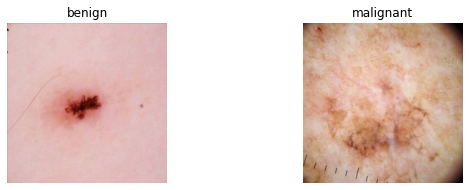

In [9]:
### Visualizing the test data

plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_test), class_)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[0]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()

In [10]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [11]:
# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[]


# Here we can make augmentation for data

In [12]:
"""Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

   Dataset.prefetch() overlaps data preprocessing and model execution while training."""

data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
print("The shape of val:",val_ds)

The shape of val: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


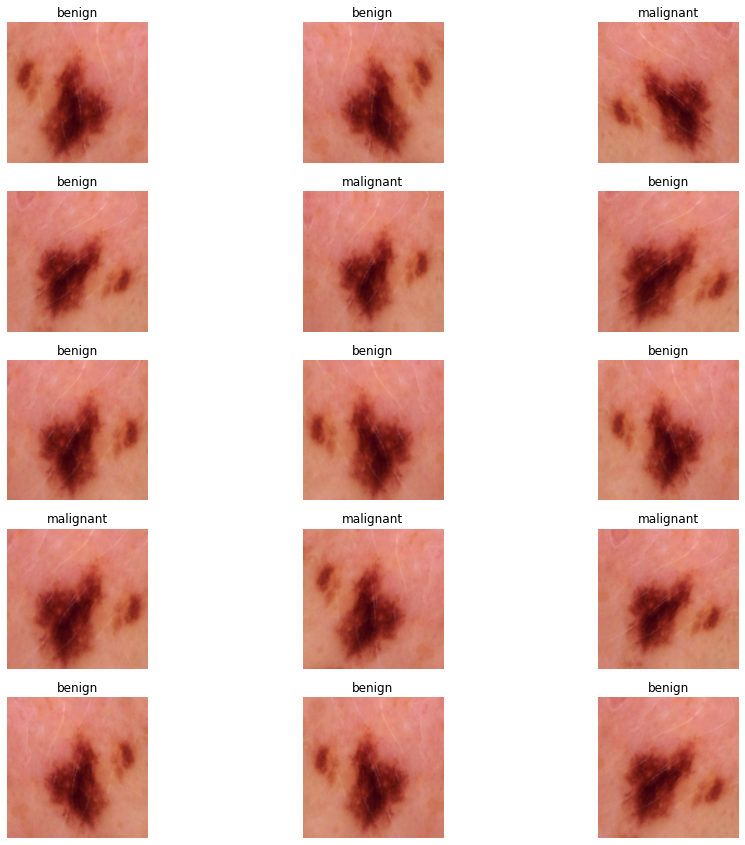

In [15]:
# Compile the model and show some of image after make augmentation
plt.figure(figsize=(15, 15))
for images, label in train_ds.take(1):
    for i in range(15):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

# Creat the first model 

In [16]:
num_classes = 9

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model = data_augmentation
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

In [17]:
# Compile the model 

## Your code goes here
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                        

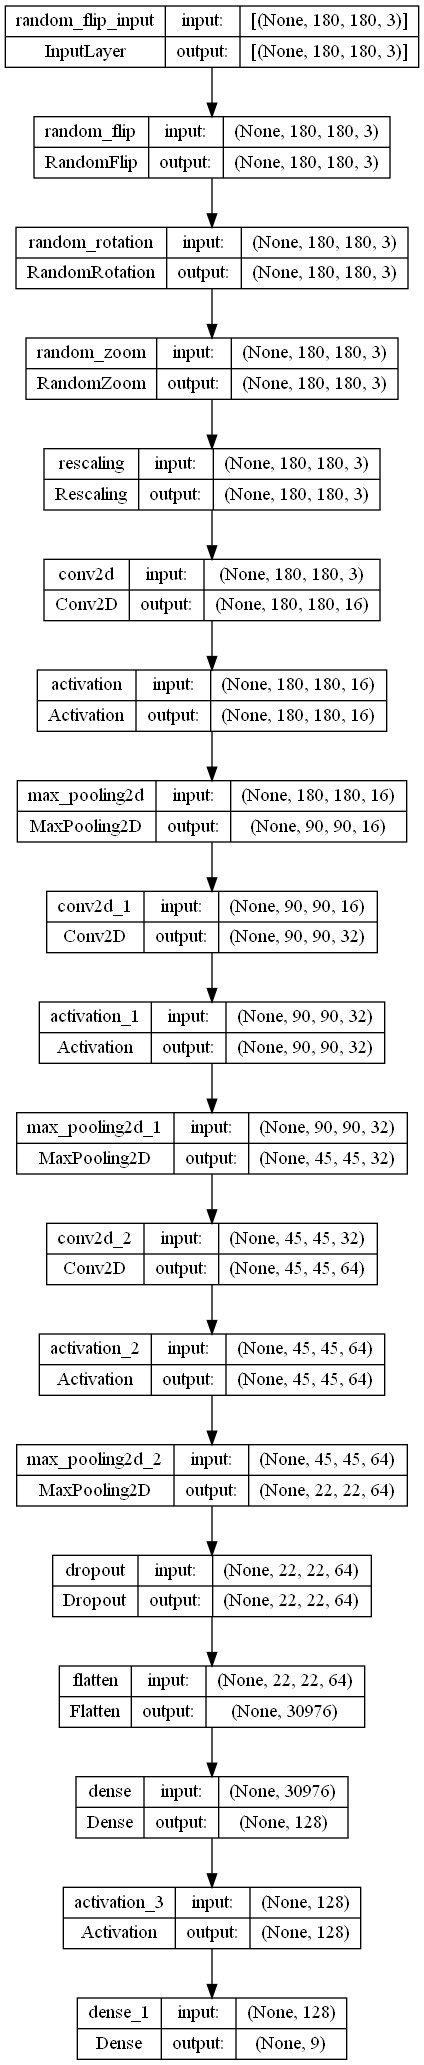

In [19]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='cnn-mnist.png', show_shapes=True)

# Training the model 


In [20]:
epochs = 100

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
66/66 [==============================] - 55s 637ms/step - loss: 0.7968 - accuracy: 0.6763 - val_loss: 0.4662 - val_accuracy: 0.7343
Epoch 2/100
66/66 [==============================] - 39s 595ms/step - loss: 0.5213 - accuracy: 0.7332 - val_loss: 0.4108 - val_accuracy: 0.8008
Epoch 3/100
66/66 [==============================] - 39s 599ms/step - loss: 0.4249 - accuracy: 0.7844 - val_loss: 0.3928 - val_accuracy: 0.8159
Epoch 4/100
66/66 [==============================] - 40s 605ms/step - loss: 0.4063 - accuracy: 0.7991 - val_loss: 0.3911 - val_accuracy: 0.8254
Epoch 5/100
66/66 [==============================] - 39s 596ms/step - loss: 0.3847 - accuracy: 0.8142 - val_loss: 0.4160 - val_accuracy: 0.8121
Epoch 6/100
66/66 [==============================] - 39s 597ms/step - loss: 0.3829 - accuracy: 0.8175 - val_loss: 0.3606 - val_accuracy: 0.8482
Epoch 7/100
66/66 [==============================] - 38s 583ms/step - loss: 0.3829 - accuracy: 0.8147 - val_loss: 0.3946 - val_accuracy:

Epoch 41/100
66/66 [==============================] - 38s 580ms/step - loss: 0.2769 - accuracy: 0.8834 - val_loss: 0.3108 - val_accuracy: 0.8691
Epoch 42/100
66/66 [==============================] - 39s 591ms/step - loss: 0.2378 - accuracy: 0.8938 - val_loss: 0.3319 - val_accuracy: 0.8786
Epoch 43/100
66/66 [==============================] - 38s 572ms/step - loss: 0.2254 - accuracy: 0.8986 - val_loss: 0.3587 - val_accuracy: 0.8653
Epoch 44/100
66/66 [==============================] - 39s 585ms/step - loss: 0.2560 - accuracy: 0.8768 - val_loss: 0.3225 - val_accuracy: 0.8805
Epoch 45/100
66/66 [==============================] - 38s 577ms/step - loss: 0.2240 - accuracy: 0.9009 - val_loss: 0.3746 - val_accuracy: 0.8710
Epoch 46/100
66/66 [==============================] - 38s 580ms/step - loss: 0.2408 - accuracy: 0.8905 - val_loss: 0.3453 - val_accuracy: 0.8861
Epoch 47/100
66/66 [==============================] - 38s 578ms/step - loss: 0.2297 - accuracy: 0.8995 - val_loss: 0.3865 - val_ac

66/66 [==============================] - 26s 393ms/step - loss: 0.1185 - accuracy: 0.9583 - val_loss: 0.5480 - val_accuracy: 0.8387
Epoch 98/100
66/66 [==============================] - 27s 405ms/step - loss: 0.0932 - accuracy: 0.9592 - val_loss: 0.5190 - val_accuracy: 0.8710
Epoch 99/100
66/66 [==============================] - 27s 404ms/step - loss: 0.0816 - accuracy: 0.9711 - val_loss: 0.7105 - val_accuracy: 0.8577
Epoch 100/100
66/66 [==============================] - 26s 400ms/step - loss: 0.0522 - accuracy: 0.9834 - val_loss: 0.5871 - val_accuracy: 0.8444


# Visualizing the results of model 

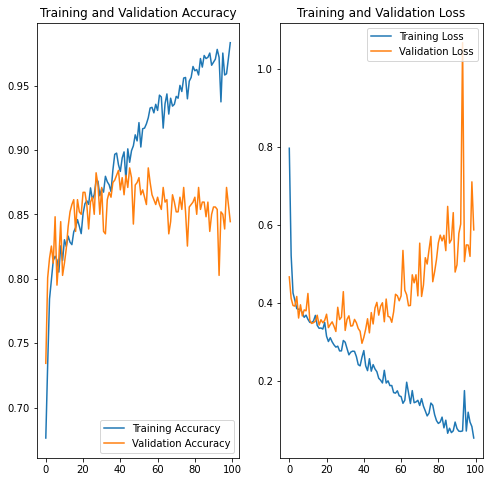

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
model.save('skin.h5')

In [23]:
class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size

{'benign': 1440, 'malignant': 1197}

In [24]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

,NumberOfSamples
benign,1440
malignant,1197


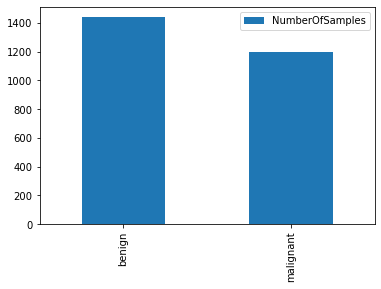

In [25]:
class_df.plot.bar()
plt.show()

# Evaluate The model 

In [26]:
test_dataset = image_dataset_from_directory(data_dir_test, image_size=(img_height, img_width), 
                                           batch_size=batch_size)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 660 files belonging to 2 classes.


Predictions:
 [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
Labels:
 [1 1 1 0 1 1 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1]


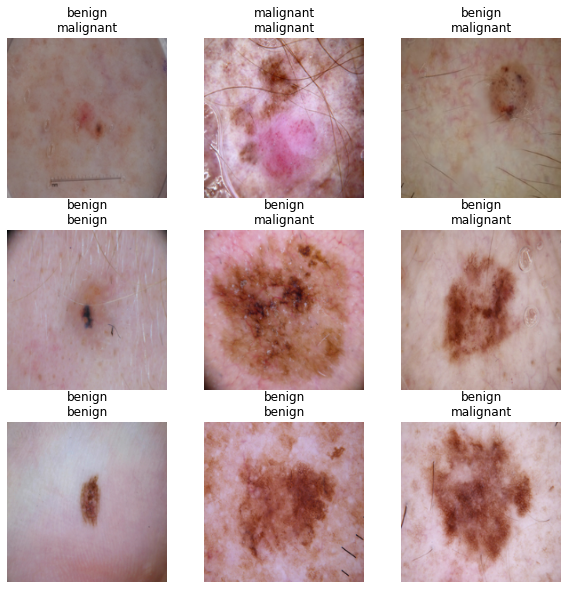

In [27]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]] + "\n" + class_names[label_batch[i]])
    plt.axis("off")